In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
import lightkurve
from lightkurve import KeplerTargetPixelFile
from lightkurve.lightcurve import LightCurve
import astropy.io.fits as fits
from astropy.io import ascii
from scipy import interpolate
import math
import scipy.special

In [2]:
desktop = '~/Desktop/'

def BATMAN_MODEL(Baseline, Rp, t = None):
    #Next we create a TransitParams object to store the physical parameters describing the transit:

    params = batman.TransitParams()
    params.t0 = 0.                       #time of inferior conjunction
    params.per = 39.09432                #period in hours
    params.rp = Rp                       #planet radius (in units of stellar radii)
    params.a = 16.                       #semi-major axis (in units of stellar radii)
    params.inc = 90.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1956, 0.3700]          #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
        
    m = batman.TransitModel(params, t)    #initializes model
    
    flux = m.light_curve(params)*Baseline        #calculates light curve
    return flux 

highres_times = np.linspace(-18, 2.5, 500)

Read in the data and convert the quantities as necessary

In [3]:
data_v1_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/visit1_blue.txt')
data_v2_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/visit2_blue.txt')
data_v1_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/visit1_red.txt')
data_v2_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/visit2_red.txt')

In [4]:
erg_v1_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit1_blue.txt')
erg_v2_blue = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit2_blue.txt')
erg_v1_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit1_red.txt')
erg_v2_red = ascii.read(desktop+'Colorado/Research/GJ1132b/GJ1132_Codes/STIS_Codes/erg_visit2_red.txt')

In [5]:
alldata = {}
alldata['V1 Blue'] = data_v1_blue['Net_photons'],data_v1_blue['Gross_photons'],data_v1_blue['Sky_photons'],data_v1_blue['Error_photons'],data_v1_blue['Time_hr'],data_v1_blue['Exptime']
alldata['V1 Red'] = data_v1_red['Net_photons'],data_v1_red['Gross_photons'],data_v1_red['Sky_photons'],data_v1_red['Error_photons'],data_v1_blue['Time_hr'],data_v1_blue['Exptime']
alldata['V2 Blue'] = data_v2_blue['Net_photons'],data_v2_blue['Gross_photons'],data_v2_blue['Sky_photons'],data_v2_blue['Error_photons'],data_v2_blue['Time_hr'],data_v2_blue['Exptime']
alldata['V2 Red'] = data_v2_red['Net_photons'],data_v2_red['Gross_photons'],data_v2_red['Sky_photons'],data_v2_red['Error_photons'],data_v2_blue['Time_hr'],data_v2_blue['Exptime']

Here, I am reading in my data

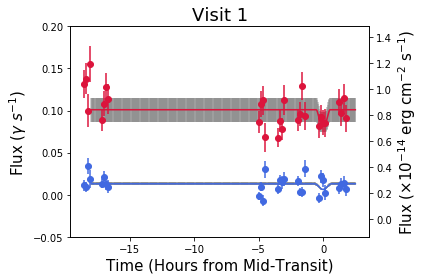

<Figure size 432x288 with 0 Axes>

In [9]:

net_red,gross_red,sky_red,error_red,data_times,exp_red = alldata['V1 Red']
net_blue,gross_blue,sky_blue,error_blue,data_times,exp_blue = alldata['V1 Blue']
erg_flux_red = erg_v1_red['Flux']
erg_flux_blue = erg_v1_blue['Flux']

times=data_times,
data_blue=net_blue/exp_blue,
data_red=net_red/exp_red,
error_blue=error_blue/exp_blue,
error_red=error_red/exp_red,
sig_scat = 0.14,
title='Visit 1'
Best_RP_blue = 0.68
Best_Base_blue = 0.013
Best_RP_red = 0.36
Best_Base_red = 0.101


# red_1 = data_red

'''
net_red,gross,sky,error_red,data_times,exp_red = alldata['V2 Red']
net_blue,gross,sky,error_blue,data_times,exp_blue = alldata['V2 Blue']
erg_flux_red = erg_v2_red['Flux']
erg_flux_blue = erg_v2_blue['Flux']

times=data_times,
data_blue=net_blue/exp_blue,
data_red=net_red/exp_red,
error_blue=error_blue/exp_blue,
error_red=error_red/exp_red,
sig_scat = 0.09,
title='Visit 2'
Best_RP_blue = 0.68
Best_Base_blue = 0.0126
Best_RP_red = 0.36
Best_Base_red = 0.136
'''

#red_1 = list(red_1[0])
#red_2 = list(red_2[0])

#red_1 += red_2

#print(len(red_1))

#data_red = np.array(red_1)

highres_model_blue = BATMAN_MODEL( Best_Base_blue, Best_RP_blue, t=highres_times)
highres_model_red = BATMAN_MODEL( Best_Base_red, Best_RP_red, t=highres_times)
    
'''
PLOT BOTH ON THE SAME AXIS
'''

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
    
ax1.plot(highres_times, highres_model_blue,color='royalblue',zorder=10)
ax1.plot(highres_times, highres_model_red,color='crimson',zorder=10)
ax1.errorbar(highres_times, highres_model_blue,yerr=sig_scat*highres_model_blue,
             color='gray',alpha=0.5,zorder=-100)
ax1.errorbar(highres_times, highres_model_red,yerr=sig_scat*highres_model_red,
             color='gray',alpha=0.5,zorder=-100)
ax1.errorbar(times,data_blue,yerr=error_blue,fmt='o',color='royalblue',zorder=100)
ax2.errorbar(times,erg_flux_blue,alpha=0)
ax2.errorbar(times,erg_flux_red,alpha=0)
ax1.errorbar(times,data_red,yerr=error_red,fmt='o',color='crimson',zorder=100)
ax1.set_xlabel('Time (Hours from Mid-Transit)',fontsize=15)
ax1.set_ylabel(r'Flux ($\gamma$ $s^{-1}$)',fontsize=15)
ax2.set_ylabel(r'Flux ($\times$10$^{-14}$ erg cm$^{-2}$ s$^{-1}$)',fontsize=15)
ax1.set_ylim(-0.05,0.2)
ax1.set_title(title,fontsize=18)
plt.tight_layout()
plt.savefig(desktop+title+'-photon-lightcurve.pdf')
plt.show()
plt.clf()

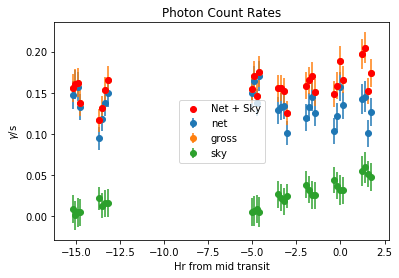

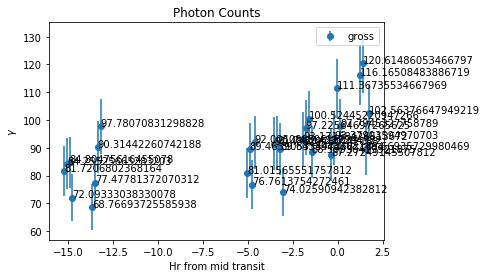

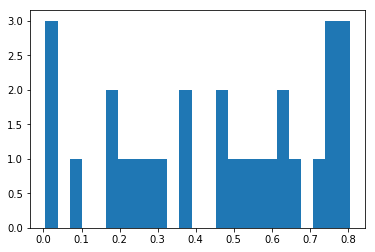

In [6]:
net,gross,sky,error,data_times,exp = alldata['V2 Red']

plt.figure()
plt.errorbar(data_times,(net/exp),yerr=(error/exp),label='net',fmt='o')
plt.errorbar(data_times,(gross/exp),yerr=(error/exp),label='gross',fmt='o')
plt.errorbar(data_times,(sky/exp),yerr=(error/exp),label='sky',fmt='o')
plt.scatter(data_times,((net/exp)+(sky/exp)),color='red',label='Net + Sky',zorder=1000)
plt.ylabel('$\gamma$/s')
plt.xlabel('Hr from mid transit')
plt.legend()
plt.title('Photon Count Rates')
plt.show()

plt.figure()
#plt.errorbar(data_times,net,yerr=error,label='net',fmt='o')

plt.errorbar(data_times,gross,yerr=error,label='gross',fmt='o')
#plt.errorbar(data_times,sky,yerr=error,label='sky',fmt='o')

for i, txt in enumerate(gross):
    plt.annotate(txt, (data_times[i],gross[i]))
    
plt.ylabel('$\gamma$')
plt.xlabel('Hr from mid transit')
plt.legend()
plt.title('Photon Counts')
plt.show()

plt.figure()
plt.hist((gross.flatten() % 1),bins=25)
plt.show()

In [5]:
Posteriors = {}
Posterior_bins = {}

In [6]:
def run_emcee(event,Model=True,Plot=True):
    
    if Model:
        # intialize some walkers
        #ndim, nwalkers, nsteps = 3, 100, 10000
        ndim, nwalkers, nsteps = 2, 100, 10000
        burnin = int(0.3*nsteps)

        # these are initial parameters
        Base1_initial = np.random.uniform(0, 1, nwalkers)
        #Base2_initial = np.random.uniform(0, 1, nwalkers)
        Rp_initial = np.random.uniform(0.1, 0.5, nwalkers)

        #p0 = np.transpose([Base1_initial, Base2_initial, Rp_initial])
        p0 = np.transpose([Base1_initial, Rp_initial])
    
        # create a sampler and run it
#         print("Now running emcee with Gaussian lnprob")
#         sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss)
#         result_gauss = sampler_gauss.run_mcmc(p0, nsteps)
    
#         Base1_gauss, Base2_gauss, Rp_gauss = sampler_gauss.chain.T[:, burnin:nsteps, :]

#         sig1_Rp_gauss = np.percentile(Rp_gauss, [16., 50., 84.])
#         print(sig1_Rp_gauss)
#         sig1_Base1_gauss = np.percentile(Base1_gauss, [16., 50., 84.])
#         print(sig1_Base1_gauss)
#         sig1_Base2_gauss = np.percentile(Base2_gauss, [16., 50., 84.])
#         print(sig1_Base2_gauss)

#         lnprob_gauss(parameters=[sig1_Base1_gauss[1],sig1_Base2_gauss[1],
#                                  sig1_Rp_gauss[1]],plot=True,event=event)
#         gauss_rp_hist,gauss_bins = np.histogram(Rp_gauss,bins=60,normed=True)
    
        print("Now running emcee with Poisson lnprob")
        sampler_poisson = emcee.EnsembleSampler(nwalkers, ndim, lnprob_poisson)
        result_poisson = sampler_poisson.run_mcmc(p0, nsteps)
    
        #Base1_poisson, Base2_poisson, Rp_poisson = sampler_poisson.chain.T[:, burnin:nsteps, :]
        Base1_poisson, Rp_poisson = sampler_poisson.chain.T[:, burnin:nsteps, :]

        sig1_Rp_poisson = np.percentile(Rp_poisson, [16., 50., 84.])
        print(sig1_Rp_poisson)
        sig1_Base1_poisson = np.percentile(Base1_poisson, [16., 50., 84.])
        print(sig1_Base1_poisson)
        #sig1_Base2_poisson = np.percentile(Base2_poisson, [16., 50., 84.])
        #print(sig1_Base2_poisson)

        #lnprob_poisson(parameters=[sig1_Base1_poisson[1],sig1_Base2_poisson[1],
        #                           sig1_Rp_poisson[1]],plot=True)
        lnprob_poisson(parameters=[sig1_Base1_poisson[1],sig1_Rp_poisson[1]],plot=True)
        
        poisson_rp_hist,poisson_bins = np.histogram(Rp_poisson,bins=60,normed=True)
    
    if Plot:
        "Plot the distributions"
        plt.figure()
        #plt.plot(gauss_bins[:-1],gauss_rp_hist,label='Gaussian PDF')
        plt.plot(poisson_bins[:-1],poisson_rp_hist,label='Poisson PDF')
        plt.title('Rp/R* Distributions')
        plt.legend(frameon=False)
        plt.xlabel('Rp/R*')
        plt.ylabel('Posterior Distrubtions')
        plt.savefig('{}_RP_Posteriors.pdf'.format(event))
        plt.show()
    
    #Posterior_bins['{} gauss'.format(event)] = gauss_bins
    #Posteriors['{} gauss'.format(event)] = gauss_rp_hist
    Posterior_bins['{} poisson'.format(event)] = poisson_bins
    Posteriors['{} poisson'.format(event)] = poisson_rp_hist

In [7]:
def lnprob_poisson(parameters, plot=False):
    
    event1 = 'V1 Blue'
    #event2 = 'V2 Red'
        
    times = highres_times
    
    net1,gross1,sky1,error1,data_times1,exp1 = alldata[event1]
    #net2,gross2,sky2,error2,data_times2,exp2 = alldata[event2]
        
    # pull out some model parameters
    #Baseline1, Baseline2, Rp = parameters
    Baseline1, Rp = parameters

    model1 = 1/(BATMAN_MODEL(Baseline1, Rp, t = data_times1)*exp1 + sky1)
    #model2 = (BATMAN_MODEL(Baseline2, Rp, t = data_times2)*exp2 + sky2)
    
    #This assumes the batman model is in photons
    
    flux_to_plot1 = BATMAN_MODEL(Baseline1, Rp, t = times)
    #flux_to_plot2 = BATMAN_MODEL(Baseline2, Rp, t = times)
    
    data1 = gross1
    #data2 = gross2
        
    if plot:
        plt.errorbar(data_times1,(net1/exp1),yerr=(error1/exp1),fmt='o',alpha = 0.5,label='V1 Data')
        plt.plot(times,flux_to_plot1,label='Rp/R* = {:.2f}'.format(Rp),color='k')
        plt.legend(frameon=False)
        plt.xlabel('Time (hr from mid transit)')
        plt.ylabel('Photons/s')
        plt.title(event1+' Poisson Fit')
        plt.savefig('Poisson_Fit_{}.pdf'.format(event1))
        plt.show()
        
#     if plot:
#         plt.errorbar(data_times2,(net2/exp2),yerr=(error2/exp2),fmt='o',alpha = 0.5,label='V2 Data')
#         plt.plot(times,flux_to_plot2,label='Rp/R* = {:.2f}'.format(Rp),color='k')
#         plt.legend(frameon=False)
#         plt.xlabel('Time (hr from mid transit)')
#         plt.ylabel('Photons/s')
#         plt.title(event2+' Poisson Fit')
#         plt.savefig('Poisson_Fit_{}.pdf'.format(event2))
#         plt.show()
        
    # this is a Poisson likelihood, for independent data points
    
    #if (0.0 < Baseline1) and (0.0 < Baseline2) and (0.0 <= Rp < 1.5):
    if (0.0 < Baseline1):
        
        k_fact1 = np.zeros_like(data1)
        #k_fact2 = np.zeros_like(data2)
        
        # we want 'data' to be the integrated gross photons
        # we want 'flux' to be integrated sky photons + integrated stellar photons (model)
        
        for i in range(len(data1)):
            k_fact1[i] = math.factorial(np.int64(data1[i]%1))
        
        lnp1 = np.sum(data1*np.log(model1) - model1 - np.log(k_fact1))
    
            
        #for i in range(len(data2)):
        #    k_fact2[i] = math.factorial(np.int64(data2[i]%1))
        
        #lnp2 = np.sum(data2*np.log(model2) - model2 - np.log(k_fact2))
    
        #return lnp1 + lnp2
        return lnp1
    
        if (lnp1 == NaN):
            lnp = -np.inf
        
        #if (lnp2 == NaN):
        #    lnp = -np.inf
    
    return -np.inf

# def lnprob_gauss(parameters, plot=False, event=Event):
        
#     times = highres_times
    
#     net,gross,sky,error,data_times,exp = alldata[event]
        
#     # pull out some model parameters
#     Baseline, Rp = parameters
    
#     model = (BATMAN_MODEL(Baseline, Rp, t = data_times)*exp + sky)
#     #This assumes the batman model is in photons
    
#     flux_to_plot = BATMAN_MODEL(Baseline, Rp, t = times)
    
#     data = gross
        
#     if plot:
#         plt.errorbar(data_times,(net/exp),yerr=(error/exp),fmt='o',alpha = 0.5,label='Data')
#         plt.plot(times,flux_to_plot,label='Rp/R* = {a:.2f}'.format(a=Rp),color='k')
#         plt.legend(frameon=False)
#         plt.xlabel('Time (hr from mid transit)')
#         plt.ylabel('Photons/s')
#         plt.title(event+' Gaussian Fit')
#         plt.savefig('Gaussian_Fit_{}.pdf'.format(event))
#         plt.show()
        

#     if (0.0 < Baseline) and (0.0 <= Rp < 1.5):
        
#         lnp = np.sum(-(1/2)*(data-model)**2.0/(error)**2.0)
        
#         return lnp
#         if lnp == NaN:
#             lnp = -np.inf
    
#     return -np.inf

likelihoods = {}
#likelihoods['gauss'] = lnprob_gauss
likelihoods['poisson'] = lnprob_poisson

In [71]:
def joint_dist(shift,pdf):
    """Create a normalized joint posterior for both events"""
    
    bins = Posterior_bins['{a} {b}'.format(a=shift,b=pdf)]
    rp_hist = Posteriors['{a} {b}'.format(a=shift,b=pdf)] 
    
    #interp_hist = np.interp(bins_v1[:-1],bins_v2[:-1],rp_hist_v2)
    #joint_dist = rp_hist_v1*interp_hist

    #CDF = np.cumsum(joint_dist)     
    CDF = np.cumsum(rp_hist)
    CDF = CDF/np.max(CDF)
    for i in range(len(CDF)):
        if (CDF[i] >= 0.95):
            twosig = i
            break

    plt.figure()
    plt.plot(bins[:-1],rp_hist,color='red')
    
    plt.axvline(bins[twosig],color='gray',linestyle='-',
                label='Red 2-$\sigma$ Rp ={:.2f}'.format(bins[twosig]))
    
    shift='Blue'
    pdf='poisson'

    bins = Posterior_bins['{a} {b}'.format(a=shift,b=pdf)]
    rp_hist = Posteriors['{a} {b}'.format(a=shift,b=pdf)] 
    
#     interp_hist = np.interp(bins_v1[:-1],bins_v2[:-1],rp_hist_v2)
#     joint_dist = rp_hist_v1*interp_hist

    #CDF = np.cumsum(joint_dist)  
    CDF = np.cumsum(rp_hist) 
    CDF = CDF/np.max(CDF)
    for i in range(len(CDF)):
        if (CDF[i] >= 0.95):
            twosig = i
            break

    #plt.plot(bins_v1[:-1],joint_dist,color='blue')
    plt.plot(bins[:-1],rp_hist,color='blue')
    plt.axvline(bins[twosig],color='gray',linestyle='--',
                label='Blue 2-$\sigma$ Rp ={:.2f}'.format(bins[twosig]))
    plt.title('Joint Rp/R* Posterior with Poisson Likelihood')
    plt.xlabel('Rp/R*')
    plt.ylabel('Normalized Distrubtion')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Blue_Red_Joint_Rp_Posterior.pdf')
    plt.show()

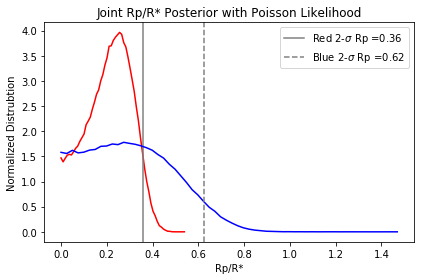

In [68]:
joint_dist(shift='Red',pdf='poisson')

In [90]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    Base, Rp = sampler.chain.T
    Base_trimmed, Rp_trimmed = sampler.chain.T[:, start:stop, :]

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(3,2, hspace=0.6)
    
    #Walker Plots
    ax_Base = plt.subplot(gs[0,0])
    ax_Base.plot(Base.flatten()[::nwalkers],color='black',alpha=0.5); 
    ax_Base.axvspan(start, stop, zorder=-1,alpha=0.3); 
    ax_Base.set_ylabel('Baseline Flux')
    
    ax_Rp = plt.subplot(gs[0,1], sharex=ax_Base)
    ax_Rp.plot(Rp.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    #Histograms
    ax_Basehist = plt.subplot(gs[1,0])
    ax_Basehist.hist(Base.flatten(),color='black',bins=60)
    #ax_Basehist.axvline(1.5,zorder=100,color='purple')
    ax_Basehist.set_xlabel('Baseline')
    ax_Basehist.set_xlim(0,10)
    
    ax_Rphist = plt.subplot(gs[1,1])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=60)
    #ax_Rphist.axvline(0.15,zorder=100,color='purple')
    ax_Rphist.set_xlabel('Rp')
    
    #Scatter Plots
    ax_both = plt.subplot(gs[2,0])
    ax_both.scatter(Base_trimmed, Rp_trimmed, s=5, alpha=0.2)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Baseline')
    ax_both.set_ylabel('Rp')